In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2023-04-25 10:00:00.745693: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 10:00:00.748555: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 10:00:00.803664: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 10:00:00.804903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 10:00:01.717083: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
map_dataset_to_path = {
    'email': './datasets/enron-spam/email_pandas.pkl',
    'sms': './datasets/sms-spam/sms_pandas.pkl',
}

def read_data(dataset):
    data = pd.read_pickle(map_dataset_to_path[dataset])
    data.dropna(inplace=True)
    return data

sms_data = read_data('sms')
email_data = read_data('email')

In [4]:
# metrics

# word count
def wc(s: str):
    return len(str.split(s))

preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") 

def get_bert_inputs(s: str, seq_length=128):
    text_tensor = tf.constant([s])
    tokenized_text = preprocessor.tokenize(text_tensor)
    bert_inputs = preprocessor.bert_pack_inputs([tokenized_text], seq_length)
    return bert_inputs

# token count
def get_token_count(s: str, seq_length=128):
    bert_inputs = get_bert_inputs(s, seq_length)
    return bert_inputs['input_mask'].numpy().sum()

2023-04-25 10:00:06.888272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-25 10:00:06.888855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-25 10:00:06.889008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-04-25 10:00:06.889500: I tensorflow/core/

In [4]:
def total_count_and_spam_share(data: pd.DataFrame):
    df = pd.DataFrame(columns=['general'], index=['count', 'spam share'])
    
    df.loc['count', 'general'] = data.shape[0]
    df.loc['spam share', 'general'] = data[data['spam'] == 1].shape[0] / df.loc['count', 'general']
    return df

def simple_analysis(data: pd.DataFrame, metric):
    data['metric'] = data['text'].apply(metric)
    metric_df = pd.DataFrame(columns=['metric total', 'metric ham', 'metric spam'], index=['mean', 'median', 'std', 'min', 'max'])
    metric_df.loc['mean', 'metric total'] = data['metric'].mean()
    metric_df.loc['median', 'metric total'] = data['metric'].median()
    metric_df.loc['std', 'metric total'] = data['metric'].std()
    metric_df.loc['min', 'metric total'] = data['metric'].min()
    metric_df.loc['max', 'metric total'] = data['metric'].max()
    metric_df.loc['mean', 'metric ham'] = data[data['spam'] == 1]['metric'].mean()
    metric_df.loc['median', 'metric ham'] = data[data['spam'] == 1]['metric'].median()
    metric_df.loc['std', 'metric ham'] = data[data['spam'] == 1]['metric'].std()
    metric_df.loc['min', 'metric ham'] = data[data['spam'] == 1]['metric'].min()
    metric_df.loc['max', 'metric ham'] = data[data['spam'] == 1]['metric'].max()
    
    metric_df.loc['mean', 'metric spam'] = data[data['spam'] == 0]['metric'].mean()
    metric_df.loc['median', 'metric spam'] = data[data['spam'] == 0]['metric'].median()
    metric_df.loc['std', 'metric spam'] = data[data['spam'] == 0]['metric'].std()
    metric_df.loc['min', 'metric spam'] = data[data['spam'] == 0]['metric'].min()
    metric_df.loc['max', 'metric spam'] = data[data['spam'] == 0]['metric'].max()
    return metric_df
    

    

In [5]:
total_count_and_spam_share(email_data)

general
count          32583
spam share  0.492251

In [6]:
simple_analysis(email_data, metric=wc)

metric total metric ham metric spam
mean      42.211122   44.74138     39.7581
median         24.0       27.0        23.0
std       63.233336  72.945635   52.002263
min               1          1           2
max            2694       2694        1030

In [7]:
def distribution_plot(data: pd.DataFrame, metric, metric_name=None, logscale=True):
    data['metric'] = data['text'].apply(metric)
    
    if metric_name is None:
        metric_name = metric.__name__
    
    if logscale:
        scale = np.unique(np.logspace(0, np.log10(data['metric'].max()), 20, dtype=int))
    else:
        scale = range(0, data['metric'].max(), 20)
    
    # ham bins
    bins_ham = pd.cut(data[data['spam'] == 0]['metric'], scale)
    counts_ham = bins_ham.value_counts().sort_index()
    
    # spam bins
    bins_spam = pd.cut(data[data['spam'] == 1]['metric'], scale)
    counts_spam = bins_spam.value_counts().sort_index()
    
    fig, ax = plt.subplots()
    counts_ham.plot(kind='bar', ax=ax, position=0, width=0.4, color='green', alpha=0.6, label='ham')
    counts_spam.plot(kind='bar', ax=ax, position=1, width=0.4, color='blue', alpha=0.6, label='spam')
    ax.set_ylabel('Number of samples')
    ax.set_xlabel(f"{metric_name.capitalize()} {'on log scale' if logscale else ''}")
    ax.set_title(f"Histogram of {metric_name}")
    ax.legend()
    plt.show()

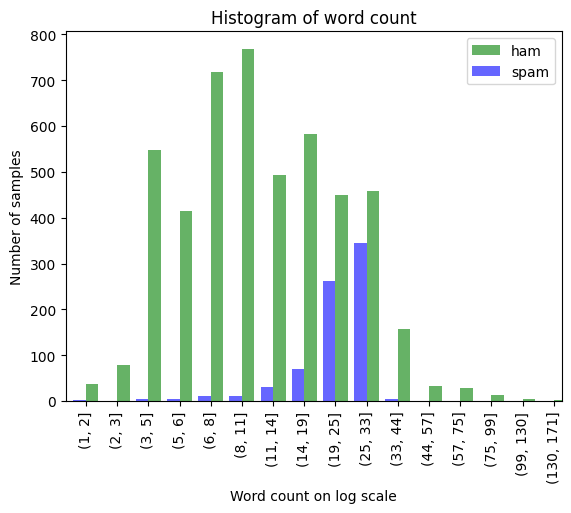

In [8]:
distribution_plot(sms_data, metric=wc, metric_name='word count', logscale=True)

2023-04-25 00:53:58.574326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?]
	 [[{{node inputs}}]]
2023-04-25 00:53:58.574403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int64 and shape [?]
	 [[{{node inputs_2}}]]


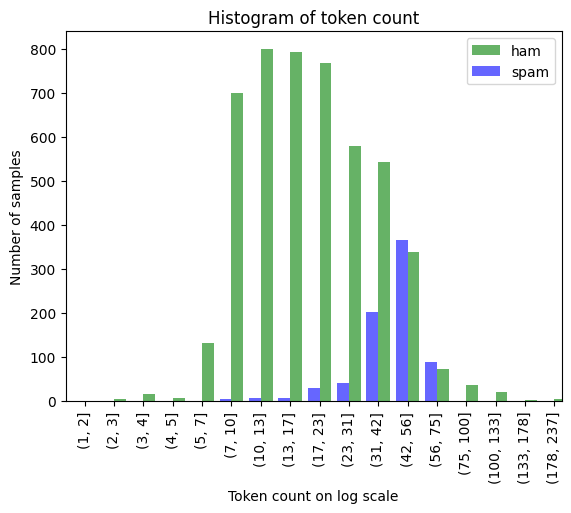

In [9]:
distribution_plot(sms_data, metric = (lambda s: get_token_count(s, seq_length=5000)), metric_name='token count')

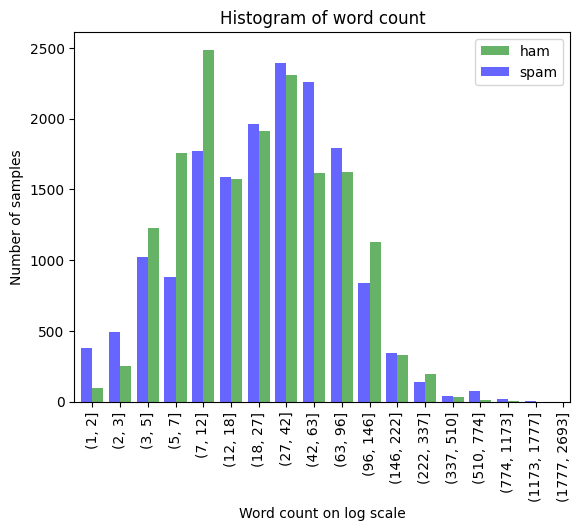

In [10]:
distribution_plot(email_data, metric=wc, metric_name='word count')

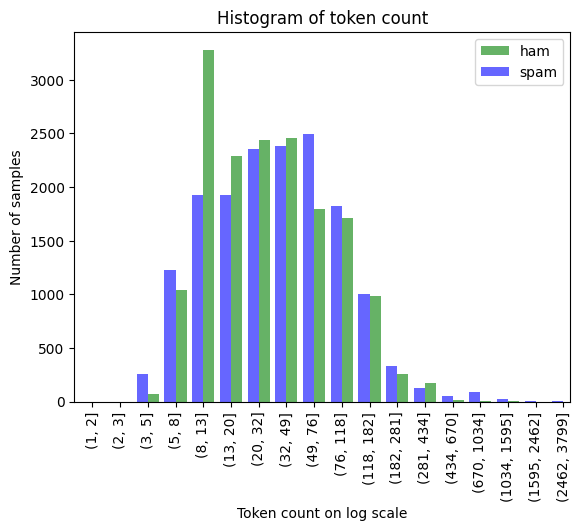

In [11]:
distribution_plot(email_data, lambda s: get_token_count(s, seq_length=5000), metric_name='token count')

In [5]:
get_bert_inputs("Hi, was geht?")

2023-04-25 10:00:09.930253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?]
	 [[{{node inputs}}]]
2023-04-25 10:00:09.930362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int64 and shape [?]
	 [[{{node inputs_2}}]]


{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 